c:\Users\rifat\miniconda3\envs\mlweb\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rifat\miniconda3\envs\mlweb\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\rifat\AppData\Local\Temp\ipykernel_916\3656640318.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.79      0.86       234
   PNEUMONIA       0.90      0.97      0.93       390
     UNKNOWN       1.00      1.00      1.00       446
TUBERCULOSIS       0.95      0.97      0.96        77

    accuracy                           0.95      1147
   macro avg       0.94      0.93      0.94      1147
weighted avg       0.95      0.95      0.94      1147



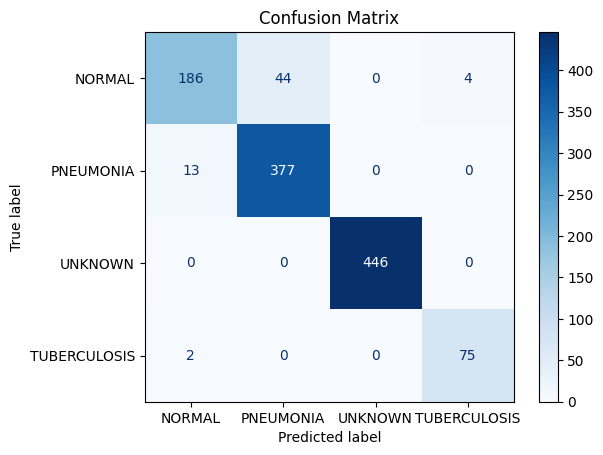

Accuracy: 94.51%


In [1]:
import os
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define transformations
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Load the pretrained ResNet-18 model and modify for 3 classes (NORMAL, PNEUMONIA, UNKNOWN)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # Modify for 3-class classification (e.g., NORMAL, PNEUMONIA, UNKNOWN)

# Load the trained model weights
model.load_state_dict(torch.load('model/model_22.pt'))
model.eval()

# Define test dataset directories
test_dir = r"D:\source\chest_xray\test"
normal_dir = os.path.join(test_dir, "NORMAL")
pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")
unknown_dir = os.path.join(test_dir, "UNKNOWN")  # Assuming you have an UNKNOWN directory
TUBERCULOSIS_dir = os.path.join(test_dir, "TUBERCULOSIS")  # Assuming you have an TUBERCULOSIS directory

# Initialize variables to store results
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Helper function to predict a single image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transformations(image)
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        predicted_label = output.argmax(dim=1).item()  # Get the class with the highest score
    return predicted_label

# Evaluate NORMAL images (Ground truth label = 0)
for image_name in os.listdir(normal_dir):
    if image_name.lower().endswith(('png', 'jpg', 'jpeg', '.bmp')):
        image_path = os.path.join(normal_dir, image_name)
        y_true.append(0)  # NORMAL = 0
        y_pred.append(predict_image(image_path))

# Evaluate PNEUMONIA images (Ground truth label = 1)
for image_name in os.listdir(pneumonia_dir):
    if image_name.lower().endswith(('png', 'jpg', 'jpeg','.bmp')):
        image_path = os.path.join(pneumonia_dir, image_name)
        y_true.append(1)  # PNEUMONIA = 1
        y_pred.append(predict_image(image_path))

# Evaluate UNKNOWN images (Ground truth label = 2)
for image_name in os.listdir(unknown_dir):
    if image_name.lower().endswith(('png', 'jpg', 'jpeg','.bmp')):
        image_path = os.path.join(unknown_dir, image_name)
        y_true.append(2)  # UNKNOWN = 2
        y_pred.append(predict_image(image_path))


# Evaluate TUBERCULOSIS images (Ground truth label = 3)
for image_name in os.listdir(TUBERCULOSIS_dir):
    if image_name.lower().endswith(('png', 'jpg', 'jpeg','.bmp')):
        image_path = os.path.join(TUBERCULOSIS_dir, image_name)
        y_true.append(3)  # TUBERCULOSIS = 3
        y_pred.append(predict_image(image_path))


# Convert results to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA", "UNKNOWN", "TUBERCULOSIS"])
print("Classification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA", "UNKNOWN", "TUBERCULOSIS"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true) * 100
print(f"Accuracy: {accuracy:.2f}%")


In [ ]:
1.5,.5,1,2.5

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import time
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Define test dataset directories
test_dir = r"D:\source\chest_xray\test"
normal_dir = os.path.join(test_dir, "NORMAL")
pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")
unknown_dir = os.path.join(test_dir, "UNKNOWN")
TUBERCULOSIS_dir = os.path.join(test_dir, "TUBERCULOSIS")

# Initialize variables to store results
model_metrics = []  # To store metrics for each model
image_output_dir = "metrics_images_2"  # Folder to save images
os.makedirs(image_output_dir, exist_ok=True)  # Create folder if not exists

# Helper function to predict a single image
def predict_image(image_path, model, transformations):
    image = Image.open(image_path).convert("RGB")
    image = transformations(image)
    image = image.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        predicted_label = output.argmax(dim=1).item()  # Get the class with the highest score
    return predicted_label
# Function to save confusion matrix as an image
def save_confusion_matrix(model_name, y_true, y_pred, save_dir):
    """
    Generate and save a confusion matrix image for the given true and predicted labels.
    """
    # Define the class labels
    classes = ["NORMAL", "PNEUMONIA", "UNKNOWN", "TUBERCULOSIS"]

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix with labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues", xticks_rotation=45)

    # Save the confusion matrix plot as an image
    plt.title(f"Confusion Matrix for {model_name}")
    image_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(image_path)
    plt.close()

# Helper function to evaluate a model
def evaluate_model(model, transformations):
    y_true = []
    y_pred = []

    # Evaluate NORMAL images (Ground truth label = 0)
    for image_name in os.listdir(normal_dir):
        if image_name.lower().endswith(('png', 'jpg', 'jpeg', '.bmp')):
            image_path = os.path.join(normal_dir, image_name)
            y_true.append(0)  # NORMAL = 0
            y_pred.append(predict_image(image_path, model, transformations))

    # Evaluate PNEUMONIA images (Ground truth label = 1)
    for image_name in os.listdir(pneumonia_dir):
        if image_name.lower().endswith(('png', 'jpg', 'jpeg', '.bmp')):
            image_path = os.path.join(pneumonia_dir, image_name)
            y_true.append(1)  # PNEUMONIA = 1
            y_pred.append(predict_image(image_path, model, transformations))

    # Evaluate UNKNOWN images (Ground truth label = 2)
    for image_name in os.listdir(unknown_dir):
        if image_name.lower().endswith(('png', 'jpg', 'jpeg', '.bmp')):
            image_path = os.path.join(unknown_dir, image_name)
            y_true.append(2)  # UNKNOWN = 2
            y_pred.append(predict_image(image_path, model, transformations))

    # Evaluate TUBERCULOSIS images (Ground truth label = 3)
    for image_name in os.listdir(TUBERCULOSIS_dir):
        if image_name.lower().endswith(('png', 'jpg', 'jpeg', '.bmp')):
            image_path = os.path.join(TUBERCULOSIS_dir, image_name)
            y_true.append(3)  # TUBERCULOSIS = 3
            y_pred.append(predict_image(image_path, model, transformations))

    # Convert results to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics
    accuracy = np.sum(y_true == y_pred) / len(y_true) * 100
    report = classification_report(y_true, y_pred, output_dict=True, target_names=["NORMAL", "PNEUMONIA", "UNKNOWN", "TUBERCULOSIS"])
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")

    # Save confusion matrix as an image


    return accuracy, f1, precision, report , y_true, y_pred


# Initialize the CSV file
output_csv = "model_metrics_2.csv"
if not os.path.exists(output_csv):
    with open(output_csv, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Model", "Accuracy", "F1 Score", "Precision", "NORMAL_F1", "NORMAL_Precision", "PNEUMONIA_F1", "PNEUMONIA_Precision", "UNKNOWN_F1", "UNKNOWN_Precision", "TUBERCULOSIS_F1", "TUBERCULOSIS_Precision"])

# Loop through all 60 models
for i in range(0,30):
    model_path = f'model_2/model_{i}.pt'
    while not os.path.exists(model_path):  # Wait until the model is created
        print(f"Model_{i} does not exist yet. Waiting for 60 seconds...")
        time.sleep(60) # Wait for 60 seconds

    try:
        # Load the model
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 4)  # Modify for 4-class classification
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)

        # Evaluate the model
        accuracy, f1, precision, report , y_true , y_pred = evaluate_model(model, transformations)
        normal_f1 = report["NORMAL"]["f1-score"]
        pneumonia_f1 = report["PNEUMONIA"]["f1-score"]
        unknown_f1 = report["UNKNOWN"]["f1-score"]
        tuberculosis_f1 = report["TUBERCULOSIS"]["f1-score"]

        # Log metrics for each class
        normal_precision = report["NORMAL"]["precision"]
        pneumonia_precision = report["PNEUMONIA"]["precision"]
        unknown_precision = report["UNKNOWN"]["precision"]
        tuberculosis_precision = report["TUBERCULOSIS"]["precision"]

        save_confusion_matrix(f"model_{i}", y_true, y_pred, image_output_dir)



        # Append model metrics to the list
        model_metrics.append({
            "model": f"model_{i}",
            "accuracy": accuracy,
            "f1": f1,
            "precision": precision,
            "normal_f1": normal_f1,
            "normal_precision": normal_precision,
            "pneumonia_f1": pneumonia_f1,
            "pneumonia_precision": pneumonia_precision,
            "unknown_f1": unknown_f1,
            "unknown_precision": unknown_precision,
            "tuberculosis_f1": tuberculosis_f1,
            "tuberculosis_precision": tuberculosis_precision
        })

        # Write metrics to CSV
        with open(output_csv, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                f"model_{i}", accuracy, f1, precision, 
                normal_f1, normal_precision, 
                pneumonia_f1, pneumonia_precision, 
                unknown_f1, unknown_precision, 
                tuberculosis_f1, tuberculosis_precision
            ])

    except Exception as e:
        print(f"Error evaluating model_{i}: {e}")







In [4]:
# Calculate a composite score for each model
for model in model_metrics:
    # Normalize scores by dividing by their max (to bring all metrics to the same scale)
    model["composite_score"] = (
        model["accuracy"] / 100 +  # Accuracy is already a percentage
        model["f1"] + 
        model["precision"] +
        model["normal_f1"] + model["normal_precision"] +
        model["pneumonia_f1"] + model["pneumonia_precision"] +
        model["unknown_f1"] + model["unknown_precision"] +
        model["tuberculosis_f1"] + model["tuberculosis_precision"]
    )

# Sort models by the composite score
sorted_models = sorted(model_metrics, key=lambda x: x["composite_score"], reverse=True)[:3]

# Print the top 3 models based on the composite score
print("Top 3 Models (Overall Composite Score):")
for idx, model_info in enumerate(sorted_models):
    print(f"Rank {idx + 1}: {model_info['model']}")
    print(f"  Composite Score: {model_info['composite_score']:.4f}")
    print(f"  Accuracy: {model_info['accuracy']:.2f}%")
    print(f"  F1 Score: {model_info['f1']:.4f}")
    print(f"  Precision: {model_info['precision']:.4f}")
    print(f"  NORMAL - F1: {model_info['normal_f1']:.4f}, Precision: {model_info['normal_precision']:.4f}")
    print(f"  PNEUMONIA - F1: {model_info['pneumonia_f1']:.4f}, Precision: {model_info['pneumonia_precision']:.4f}")
    print(f"  UNKNOWN - F1: {model_info['unknown_f1']:.4f}, Precision: {model_info['unknown_precision']:.4f}")
    print(f"  TUBERCULOSIS - F1: {model_info['tuberculosis_f1']:.4f}, Precision: {model_info['tuberculosis_precision']:.4f}")
    print()

Top 3 Models (Overall Composite Score):
Rank 1: model_6
  Composite Score: 10.0091
  Accuracy: 90.85%
  F1 Score: 0.9006
  Precision: 0.9241
  NORMAL - F1: 0.7139, Precision: 0.9850
  PNEUMONIA - F1: 0.8869, Precision: 0.8000
  UNKNOWN - F1: 1.0000, Precision: 1.0000
  TUBERCULOSIS - F1: 0.9625, Precision: 0.9277

Rank 2: model_7
  Composite Score: 10.0048
  Accuracy: 90.24%
  F1 Score: 0.8934
  Precision: 0.9212
  NORMAL - F1: 0.6889, Precision: 0.9841
  PNEUMONIA - F1: 0.8771, Precision: 0.7827
  UNKNOWN - F1: 1.0000, Precision: 1.0000
  TUBERCULOSIS - F1: 0.9806, Precision: 0.9744

Rank 3: model_3
  Composite Score: 9.9445
  Accuracy: 90.41%
  F1 Score: 0.8952
  Precision: 0.9211
  NORMAL - F1: 0.6961, Precision: 0.9844
  PNEUMONIA - F1: 0.8841, Precision: 0.7939
  UNKNOWN - F1: 1.0000, Precision: 1.0000
  TUBERCULOSIS - F1: 0.9500, Precision: 0.9157

